In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [2]:
def linear_costs(x, y, z, theta):
    costs = (np.matmul(x,theta)-z)*(1-2*y)
    return costs

In [3]:
def paired_classifier(x, costs):
    f = []
    for cost in costs.T:
        f.append(LinearRegression().fit(x, cost))
    return f

In [4]:
def obj_grad(objective, x, z, theta, n):
    if objective=='MSE':
        grad = 2*np.matmul(x.T,np.matmul(x,theta)-z)/n
        return grad.flatten()
    elif objective=='dot_product':
        grad = np.matmul(x.T,z)/n
        return grad.flatten()
    else:
        return 0

In [18]:
def linear_proxies(x, y, z_all, C, iters, n, K, objective=None):
    theta_list = []
    grad_list = []
    for k in range(0,K):
        z = z_all[:,k].reshape(-1,1)
        zhat = LinearRegression().fit(x, z)
        theta = [np.transpose(zhat.coef_)]
        grad_l = []
        for t in range(1, iters):
            costs = linear_costs(x, y, z, theta[t-1])
            f_s = paired_classifier(x, costs)
            val = []
            h= [0]*n
            for i, f in enumerate(f_s):
                h_s = f.predict(x)
                h[i] = h_s < 0
                val.append(np.sum(h_s[h[i]]))
            y_index = np.argmin(val)
            y_temp = y[:,y_index]
            h = h[y_index].astype(int)
            if np.abs((np.sum(np.matmul(x,theta[t-1]))/np.sum(z)) - 1) >= np.abs(np.matmul((np.matmul(x,theta[t-1])-z).T,np.abs(h-y_temp))):
                penalty = np.sign((np.sum(np.matmul(x,theta[t-1]))/np.sum(z)) - 1) * np.sum(x, axis=0)/np.sum(z)
            else:
                penalty = np.sign(np.matmul(np.transpose(np.matmul(x,theta[t-1])-z),np.abs(h-y_temp))) * np.matmul(np.transpose(x),np.abs(h-y_temp))  
                penalty = penalty.flatten()
            grad_l.append(obj_grad(objective,x,z,theta[t-1],n) + C * penalty) 
            theta.append(theta[t-1] - (np.power(t, -1/2) * grad_l[t-1]).reshape(-1,1))
        theta_list.append(theta)
        grad_list.append(grad_l)
    return theta_list, grad_list

In [ ]:
def calculate_hyperparameter_C(z, n, M, alpha):
    C = (np.square(M)+2*(alpha*np.sum(z)/(1+n*M)))/(alpha*np.sum(z)/(1+n*M))
    return C

def calculate_hyperparameter_T(d, B, C, M, alpha, z, n):
    T = ((d+1)**4)*np.square(2*M*B+n*C*B*(alpha*np.sum(z)/(1+n*M)))/np.square((alpha*np.sum(z)/(1+n*M)))
    return int(T)

In [ ]:
# np.random.seed(1) #Good
np.random.seed(2) #Bad

n = 10
m = 1
K = 1
d = 1

M = 2
B = 1
alpha = 0.3

trials = 10
intercept = np.ones(n).reshape(-1,1)
discrepancy = []

for i in range(0,trials):
    x_train = np.random.rand(n,d)
    x_train = np.hstack((intercept, x_train))
    y_train = np.round(np.random.rand(n,m))
    z_train = np.round(np.random.rand(n,K))
    
    C = calculate_hyperparameter_C(z_train, n, M, alpha)
    T = calculate_hyperparameter_T(d, B, C, M, alpha, z_train, n)

    coefficients, gradients = linear_proxies(x_train, y_train, z_train, C, T, n, K)

    final_model = np.mean(coefficients, axis=1)
    final_costs = linear_costs(x_train, y_train, z_train, final_model)
    prc = paired_classifier(x_train, final_costs)
    h_s = prc[0].predict(x_train)
    h = h_s < 0
    h_int = h.astype(int)
    h_err = h_int != y_train
    z_hat = np.matmul(x_train, final_model[0])
    print(z_hat)
    print(z_train)
    #Check discrepancy
    discrepancy.append(np.mean(z_train[h_err])/(np.mean(z_train)) - np.mean(z_hat[h_err])/(np.mean(z_hat)))
    
print(discrepancy)
print(np.mean(discrepancy))

[[-0.0247473 ]
 [ 1.90317126]
 [-0.55915006]
 [-0.02158553]
 [ 0.04872278]
 [ 0.4720086 ]
 [ 1.0629163 ]
 [-0.88641109]
 [ 0.61624987]
 [ 0.77058634]]
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.81718092]
 [1.11807189]
 [0.62195186]
 [0.79989688]
 [0.77482655]
 [0.90867143]
 [0.44865083]
 [0.69026599]
 [1.16268301]
 [0.55370212]]
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]]
[[0.43709225]
 [0.75758218]
 [0.49410062]
 [1.45623375]
 [1.25629574]
 [0.8831517 ]
 [1.15357769]
 [1.65576589]
 [0.1417099 ]
 [1.01673458]]
[[1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]]
[[ 1.89423604]
 [ 3.38232204]
 [-0.43629074]
 [ 0.00711529]
 [ 2.43486353]
 [ 1.32690066]
 [ 0.08205358]
 [-0.01464153]
 [ 2.67693093]
 [-1.22156799]]
[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]


(array([1., 0., 0., 0., 1., 3., 2., 0., 1., 2.]),
 array([-0.99893649, -0.82265711, -0.64637772, -0.47009834, -0.29381896,
        -0.11753957,  0.05873981,  0.23501919,  0.41129858,  0.58757796,
         0.76385734]),
 <BarContainer object of 10 artists>)

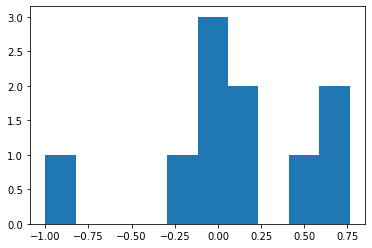

In [34]:
plt.hist(discrepancy)

#Portion of discrepancies that fall in good range

In [ ]:
coefficients_0 = [row[0] for row in coefficients[0]]
plt.plot(coefficients_0)

In [ ]:
coefficients_1 = [row[2] for row in coefficients[1]]
plt.plot(coefficients_1)

In [ ]:
gradients_0 = [row[0] for row in gradients[0]]
plt.plot(gradients_0)

In [ ]:
gradients_1 = [row[1] for row in gradients[1]]
plt.plot(gradients_1)

In [ ]:
#np.random.seed(1)
n = 100
m = 1
K = 3
d = 2
intercept = np.ones(n).reshape(-1,1)
x_train = np.random.rand(n,d)
x_train = np.hstack((intercept, x_train))
y_train = np.round(np.random.rand(n,m))
z_train = np.round(np.random.rand(n,K))


nonlinear_proxies(x_train, y_train, z_train, 1, 100000, 10, 100, 4)

def nonlinear_proxies(x, y, z_all, C, T, W, n, K, objective=None):
    zhat_list = []
    for t in range(0,T):
        noise = np.random.rand(n,W)
        for w in range(0,W):
            noise_w = noise[:,w]
            Basically find lambda the same way